<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/shock_tube_mhd_chem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1‑D Ideal‑MHD shock tube with optional Arrhenius chemistry

This notebook reproduces a Brio–Wu–type shock tube and optionally includes
a single‑step exothermic reaction `Fuel → Product + Q`.  
Solver: first‑order Godunov with HLL flux (easy to read, not production‑grade).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ---------------- parameters ----------------
GAMMA = 1.4
CFL   = 0.3
NX    = 400
XL, XR = 0.0, 1.0
DX = (XR-XL)/NX
T_FINAL = 0.1
B_X = 0.75

# Chemistry
Ea   = 2.5e5   # J/mol
k0   = 1.0e9   # 1/s
Q_HEAT = 4.3e6 # J/kg
Rgas = 8.314
CHEMISTRY_ON = True

In [ ]:
# ---------------- helper functions ----------
def reaction_rate(rho, T, Yf):
    """Arrhenius ω̇ (kg_F m⁻³ s⁻¹)."""
    return rho * k0 * Yf * np.exp(-Ea/(Rgas*T))

def prim_to_cons(rho,u,v,w,p,By,Bz,Yf):
    B2 = B_X**2 + By**2 + Bz**2
    E  = p/(GAMMA-1) + 0.5*rho*(u*u+v*v+w*w) + 0.5*B2
    return np.array([rho, rho*u, rho*v, rho*w, By, Bz, E, rho*Yf])

def pressure(U):
    rho,mx,my,mz,By,Bz,E,_ = U
    kin = 0.5*(mx*mx+my*my+mz*mz)/rho
    mag = 0.5*(B_X**2 + By**2 + Bz**2)
    return (GAMMA-1)*(E - kin - mag)

def cons_to_flux(U):
    rho,mx,my,mz,By,Bz,E,rhoYf = U
    u,v,w = mx/rho, my/rho, mz/rho
    p     = pressure(U)
    B2    = B_X**2 + By**2 + Bz**2
    p_star = p + 0.5*B2
    velB   = B_X*u + By*v + Bz*w
    F = np.empty_like(U)
    F[0] = rho*u
    F[1] = rho*u*u + p_star - B_X*B_X
    F[2] = rho*u*v - B_X*By
    F[3] = rho*u*w - B_X*Bz
    F[4] = By*u - B_X*v
    F[5] = Bz*u - B_X*w
    F[6] = (E+p_star)*u - B_X*velB
    F[7] = rhoYf*u
    return F

def fast_speed(rho,p,By,Bz):
    """Vectorised fast magnetosonic speed."""
    rho = np.asarray(rho); p = np.asarray(p); By=np.asarray(By); Bz=np.asarray(Bz)
    a2 = GAMMA*p/rho
    B2 = B_X**2 + By**2 + Bz**2
    ca2= B_X**2 / rho
    disc = (a2 + B2/rho)**2 - 4*a2*ca2
    cf2 = 0.5*((a2 + B2/rho) + np.sqrt(np.maximum(disc,0)))
    return np.sqrt(cf2)

def hll(UL,UR):
    rhoL,mxL,*restL = UL
    rhoR,mxR,*restR = UR
    ByL,BzL = UL[4], UL[5]
    ByR,BzR = UR[4], UR[5]
    pL, pR  = pressure(UL), pressure(UR)
    uL, uR  = mxL/rhoL, mxR/rhoR
    cL = fast_speed(rhoL,pL,ByL,BzL)
    cR = fast_speed(rhoR,pR,ByR,BzR)
    SL = min(uL,uR) - max(cL,cR)
    SR = max(uL,uR) + max(cL,cR)
    FL, FR = cons_to_flux(UL), cons_to_flux(UR)
    if SL >= 0: return FL
    if SR <= 0: return FR
    return (SR*FL - SL*FR + SL*SR*(UR-UL))/(SR-SL)

In [ ]:
# --------------- initial data -----------------
left  = dict(rho=1.0,   u=0.,v=0.,w=0., p=1.0,  By=1.0,  Bz=0., Yf=1.0)
right = dict(rho=0.125, u=0.,v=0.,w=0., p=0.1, By=-1.0, Bz=0., Yf=1.0)

x = np.linspace(XL+0.5*DX, XR-0.5*DX, NX)
prim = {k: np.where(x<0.5, left[k], right[k]) for k in left}

U = np.stack([prim_to_cons(
        prim['rho'][i], prim['u'][i], prim['v'][i], prim['w'][i],
        prim['p'][i],   prim['By'][i], prim['Bz'][i], prim['Yf'][i]
    ) for i in range(NX)], axis=1)

In [ ]:
# --------------- time integration -------------
t = 0.0
while t < T_FINAL:
    p_local = np.array([pressure(U[:,i]) for i in range(NX)])
    a = fast_speed(U[0], p_local, U[4], U[5])
    max_speed = np.max(np.abs(U[1]/U[0]) + a)
    dt = CFL*DX/max_speed
    if t + dt > T_FINAL:
        dt = T_FINAL - t

    # fluxes
    F = np.zeros((8, NX+1))
    for i in range(NX+1):
        UL = U[:, i-1] if i>0 else U[:,0]
        UR = U[:, i]   if i<NX else U[:, -1]
        F[:, i] = hll(UL, UR)

    # update conserved
    U -= dt/DX * (F[:,1:] - F[:,:-1])

    # chemistry source
    if CHEMISTRY_ON:
        rho = U[0]; rhoYf = U[7]
        Yf  = np.clip(rhoYf/rho, 0, 1)
        p   = np.array([pressure(U[:,i]) for i in range(NX)])
        T   = p / (rho*(GAMMA-1))
        omega = reaction_rate(rho, T, Yf)
        U[7] += -omega * dt
        U[6] += -Q_HEAT * omega * dt

    t += dt

print(f'Done: t = {t:.3f}')

Done: t = 0.100


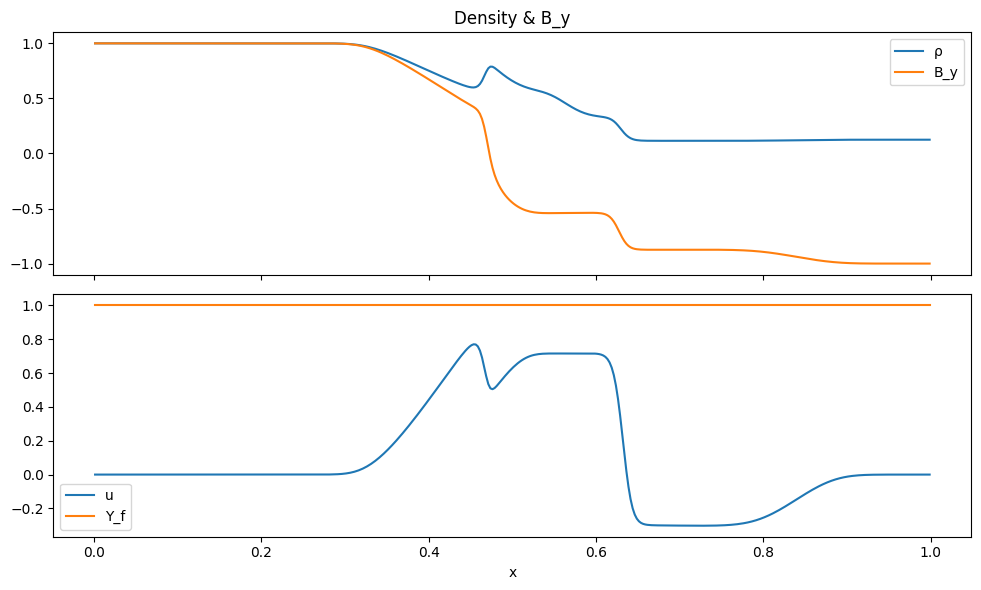

In [ ]:
# ------------- plots --------------------------
rho = U[0]
By  = U[4]
u   = U[1]/U[0]
Yf  = np.clip(U[7]/U[0], 0, 1)

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(x, rho, label='ρ')
ax[0].plot(x, By,  label='B_y')
ax[0].legend(); ax[0].set_title('Density & B_y')

ax[1].plot(x, u,  label='u')
ax[1].plot(x, Yf, label='Y_f')
ax[1].legend(); ax[1].set_xlabel('x')

plt.tight_layout()
plt.show()